# 1. Gerekli K√ºt√ºphaneler ve Ayarlar

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from skimage.measure import label, regionprops
import shutil

In [3]:
# Random seed ayarƒ±
random.seed(42)

# G√∂rselle≈ütirme ayarlarƒ±
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'

# 2. Klas√∂r Yapƒ±sƒ± Kontrol√º

In [4]:
def validate_folder_structure():
    # Temel klas√∂r yollarƒ±
    BASE_DIR = os.getcwd()
    IMAGE_DIR = os.path.join(BASE_DIR, 'images')
    REQUIRED_FOLDERS = [
        'images/test/0',
        'images/test/1',
        'images/train/0', 
        'images/train/1'
    ]
    
    # Klas√∂rleri kontrol et
    missing_folders = []
    for folder in REQUIRED_FOLDERS:
        if not os.path.exists(os.path.join(BASE_DIR, folder)):
            missing_folders.append(folder)
    
    if missing_folders:
        print("HATA: Eksik klas√∂rler bulundu!")
        for folder in missing_folders:
            print(f"- {folder}")
        print("\nL√ºtfen klas√∂r yapƒ±sƒ±nƒ± a≈üaƒüƒ±daki gibi olu≈üturun:")
        print("""
        proje_klasoru/
        ‚îú‚îÄ‚îÄ images/
        ‚îÇ   ‚îú‚îÄ‚îÄ test/
        ‚îÇ   ‚îÇ   ‚îú‚îÄ‚îÄ 0/
        ‚îÇ   ‚îÇ   ‚îî‚îÄ‚îÄ 1/
        ‚îÇ   ‚îî‚îÄ‚îÄ train/
        ‚îÇ       ‚îú‚îÄ‚îÄ 0/
        ‚îÇ       ‚îî‚îÄ‚îÄ 1/
        ‚îî‚îÄ‚îÄ Brain_Extraction.ipynb""")
        return False
    return True

if not validate_folder_structure():
    raise Exception("L√ºtfen klas√∂r yapƒ±sƒ±nƒ± d√ºzeltin!")

# 3. G√∂r√ºnt√º ƒ∞≈üleme Fonksiyonlarƒ±

In [5]:
def process_image(image):
    """Beyin ekstraksiyonu i√ßin ana i≈ülem fonksiyonu"""
    try:
        # 1. √ñn i≈ülem
        temp_img = image.copy()
        temp_img[temp_img == 255] = 0
        
        # 2. Thresholding
        _, binary = cv2.threshold(temp_img, 1, 1, cv2.THRESH_BINARY)
        
        # 3. Morfolojik i≈ülemler
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opened = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
        
        # 4. En b√ºy√ºk baƒülantƒ±lƒ± bile≈üen
        labeled = label(opened)
        regions = regionprops(labeled)
        
        if not regions:
            return image  # ƒ∞≈ülem yapƒ±lamazsa orijinali d√∂nd√ºr
        
        largest_region = max(regions, key=lambda r: r.area)
        mask = (labeled == largest_region.label).astype(np.uint8)
        
        return image * mask
    except Exception as e:
        print(f"ƒ∞≈ülem hatasƒ±: {str(e)}")
        return image

def visualize_sample(original, processed, title):
    """Rastgele se√ßilmi≈ü √∂rnekleri g√∂rselle≈ütir"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original)
    ax1.set_title(f'Original\n{title}')
    ax1.axis('off')
    
    ax2.imshow(processed)
    ax2.set_title(f'Processed\n{title}')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# 4. Ana ƒ∞≈ülem D√∂ng√ºs√º

In [6]:
def run_pipeline():
    BASE_DIR = os.getcwd()
    IMAGE_DIR = os.path.join(BASE_DIR, 'images')
    RESULT_DIR = os.path.join(BASE_DIR, 'result')
    
    # √áƒ±ktƒ± klas√∂rlerini olu≈ütur
    os.makedirs(RESULT_DIR, exist_ok=True)
    for dataset in ['test', 'train']:
        for class_label in ['0', '1']:
            os.makedirs(os.path.join(RESULT_DIR, dataset, class_label), exist_ok=True)
    
    # T√ºm g√∂r√ºnt√ºleri i≈üle
    for dataset in ['test', 'train']:
        for class_label in ['0', '1']:
            img_files = glob(os.path.join(IMAGE_DIR, dataset, class_label, '*.jpg')) + \
                       glob(os.path.join(IMAGE_DIR, dataset, class_label, '*.png'))
            
            if not img_files:
                print(f"Uyarƒ±: {dataset}/{class_label} klas√∂r√º bo≈ü!")
                continue
                
            # Rastgele 5 √∂rnek se√ß
            viz_samples = random.sample(img_files, min(5, len(img_files)))
            
            for img_path in img_files:
                try:
                    # G√∂r√ºnt√ºy√º y√ºkle
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Y√ºkleme hatasƒ±: {img_path}")
                        continue
                    
                    # ƒ∞≈üle
                    processed_img = process_image(img)
                    
                    # Kaydet
                    img_name = os.path.basename(img_path)
                    save_path = os.path.join(RESULT_DIR, dataset, class_label, img_name)
                    cv2.imwrite(save_path, processed_img)
                    
                    # G√∂rselle≈ütirme
                    if img_path in viz_samples:
                        title = f"{dataset}/{class_label}/{img_name}"
                        visualize_sample(img, processed_img, title)
                        
                except Exception as e:
                    print(f"Hata: {img_path} - {str(e)}")
    
    print("‚úÖ T√ºm i≈ülemler ba≈üarƒ±yla tamamlandƒ±!")
    print(f"Sonu√ßlar '{RESULT_DIR}' klas√∂r√ºne kaydedildi.")


# 5. ƒ∞≈ülemleri Ba≈ülat

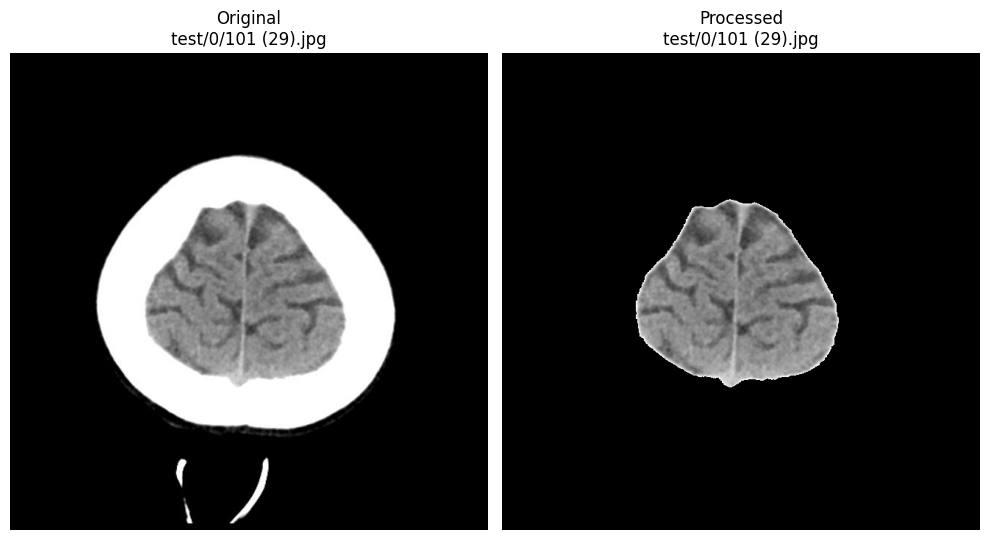

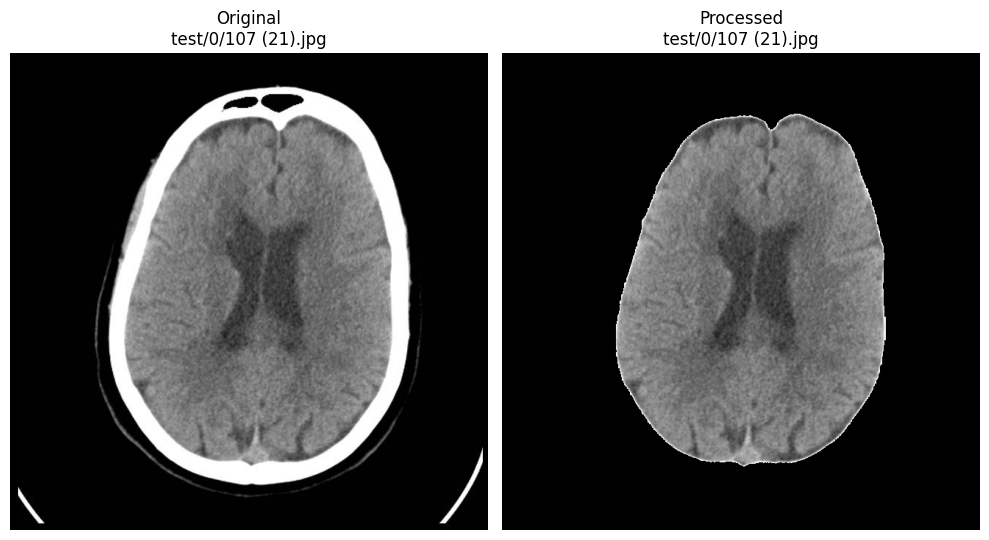

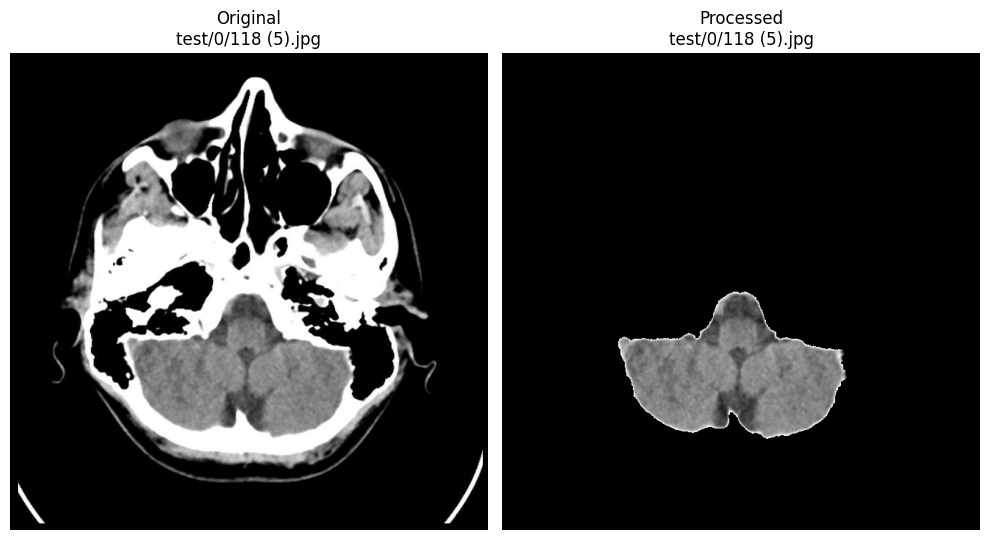

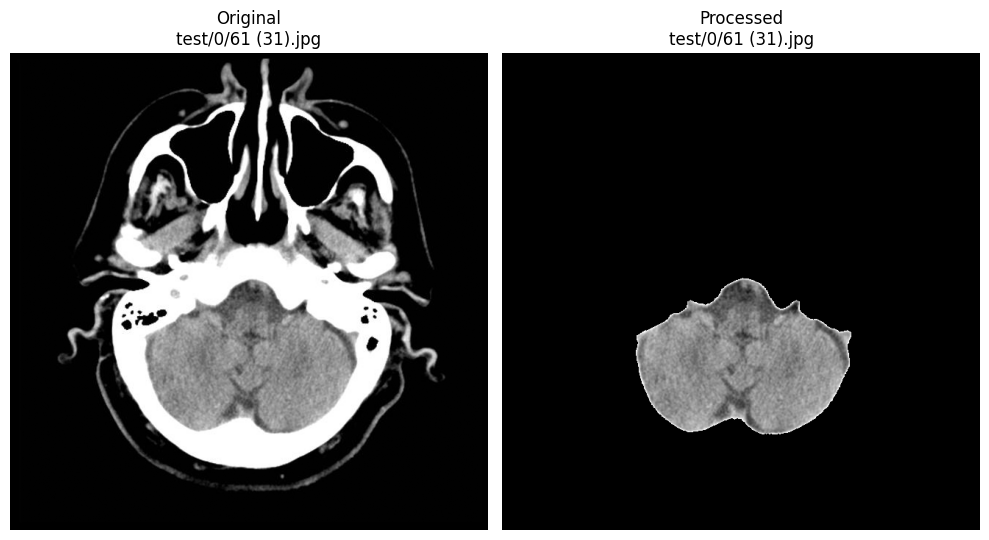

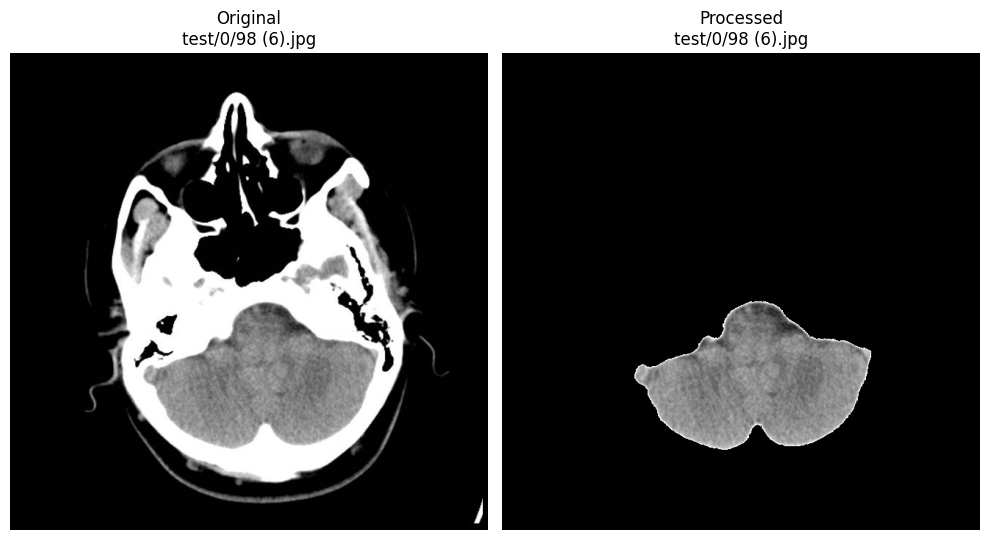

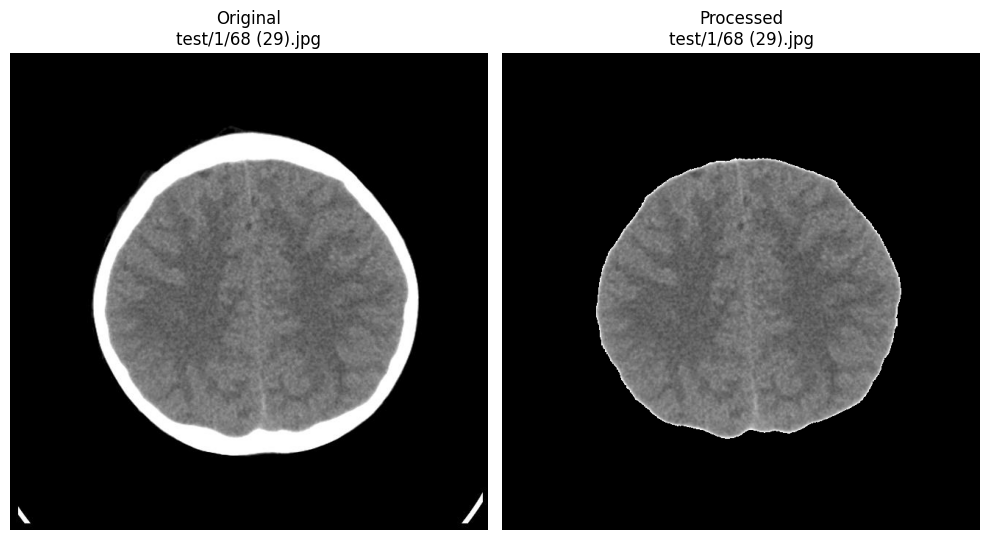

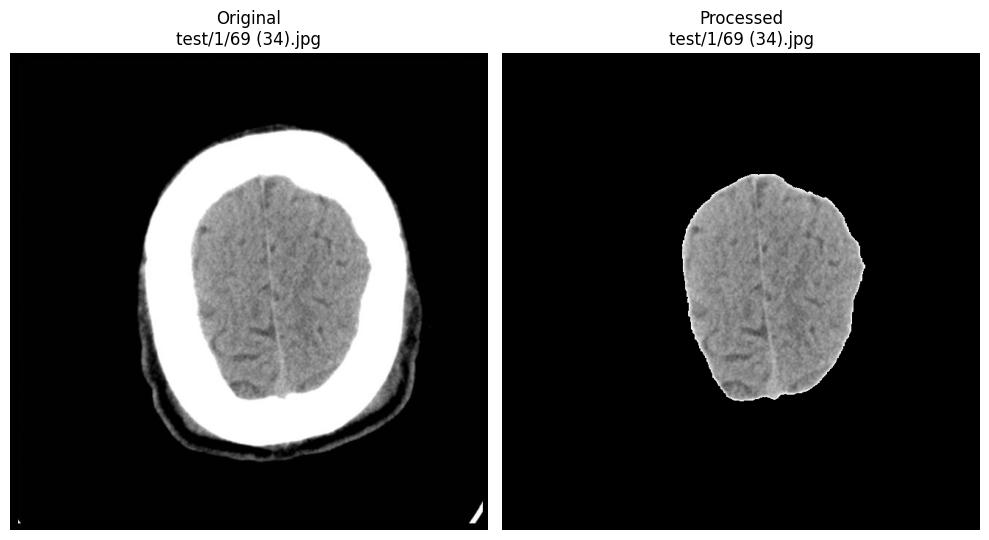

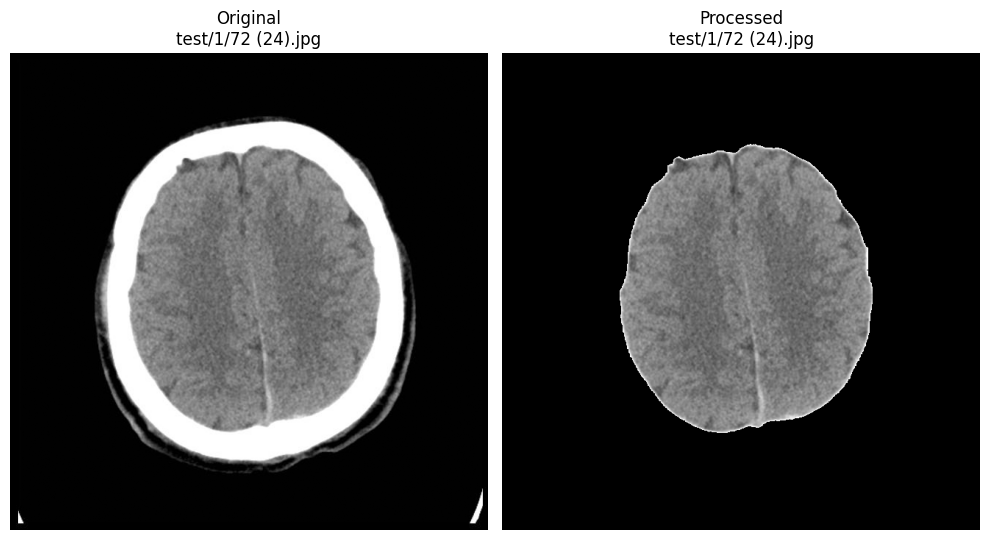

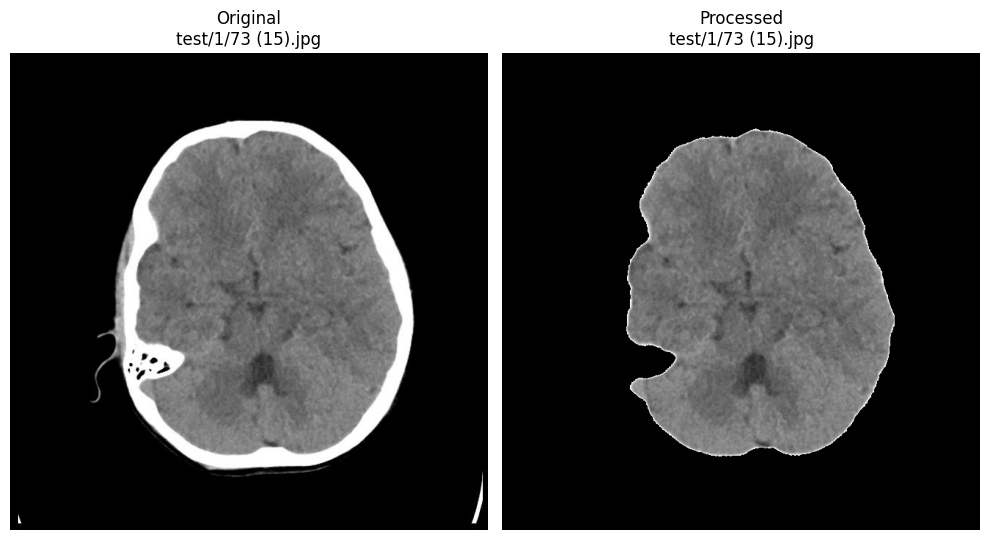

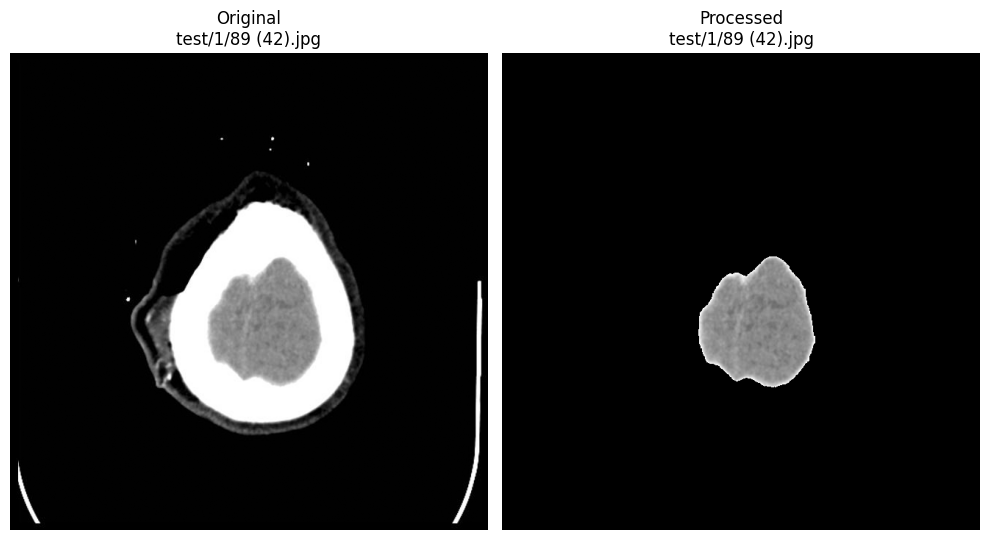

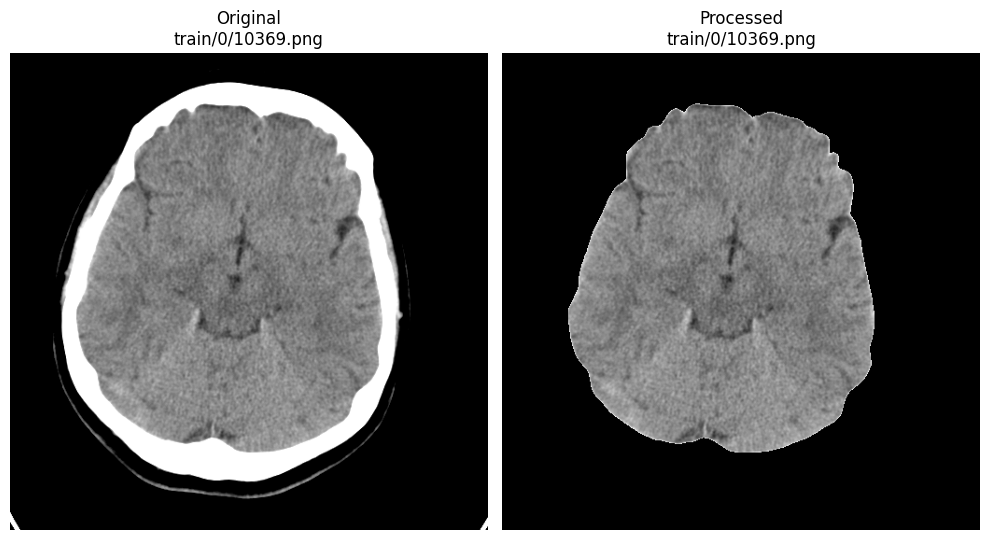

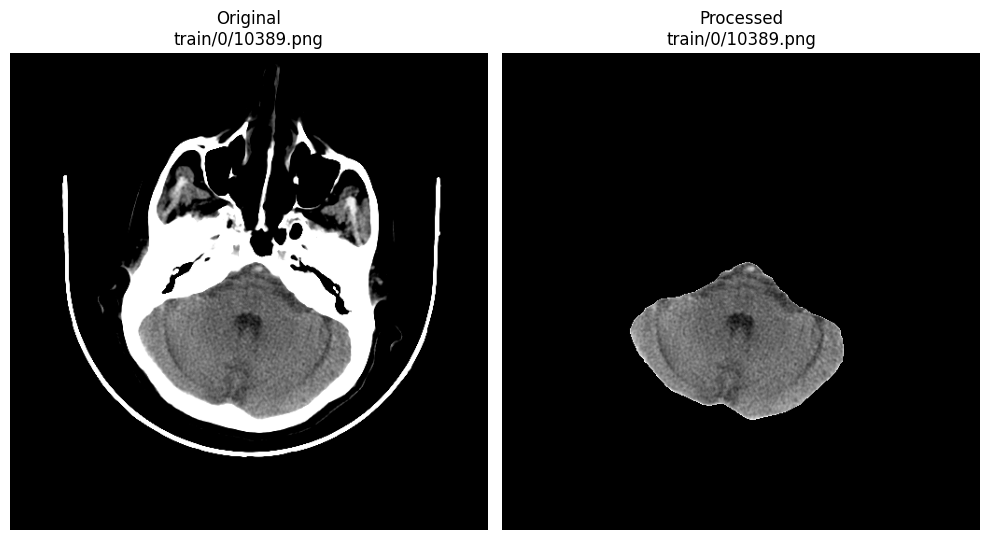

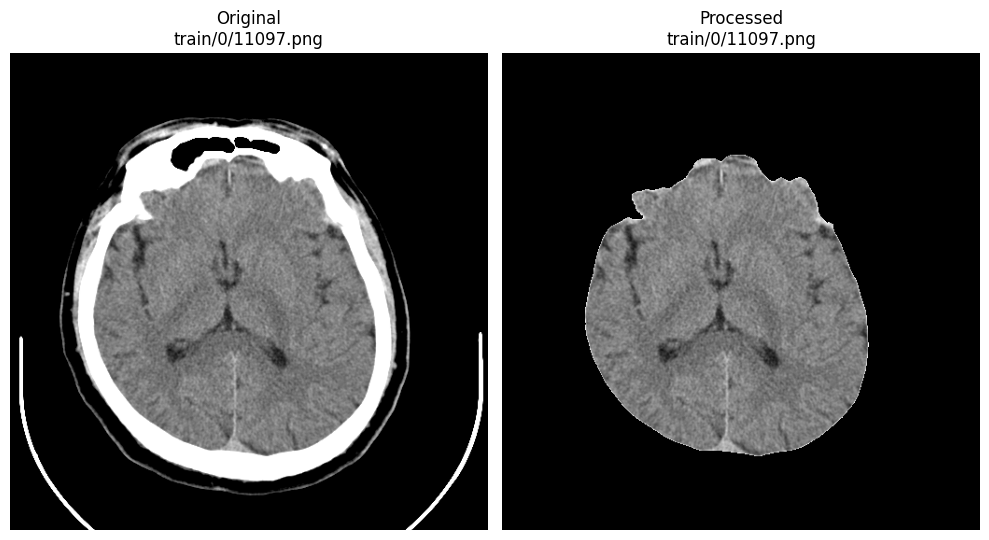

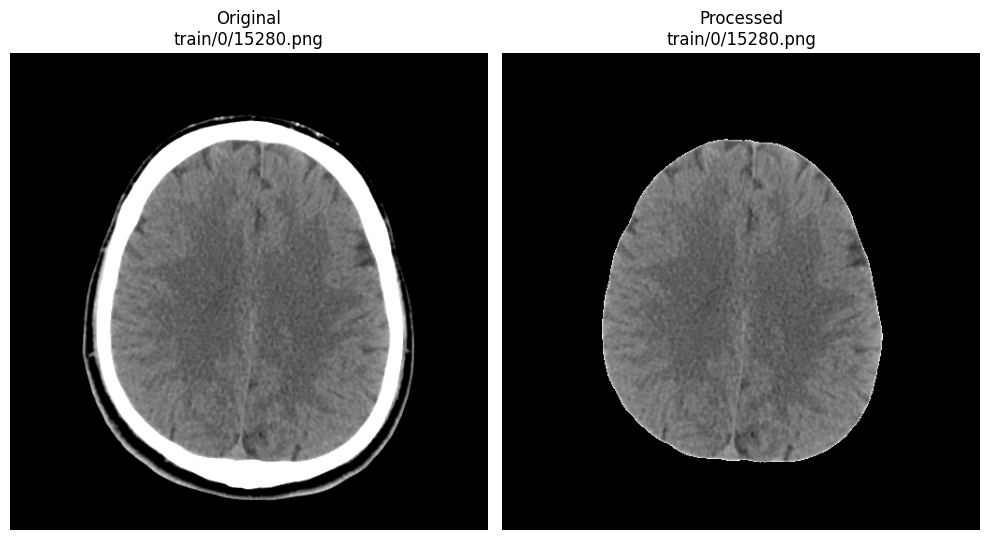

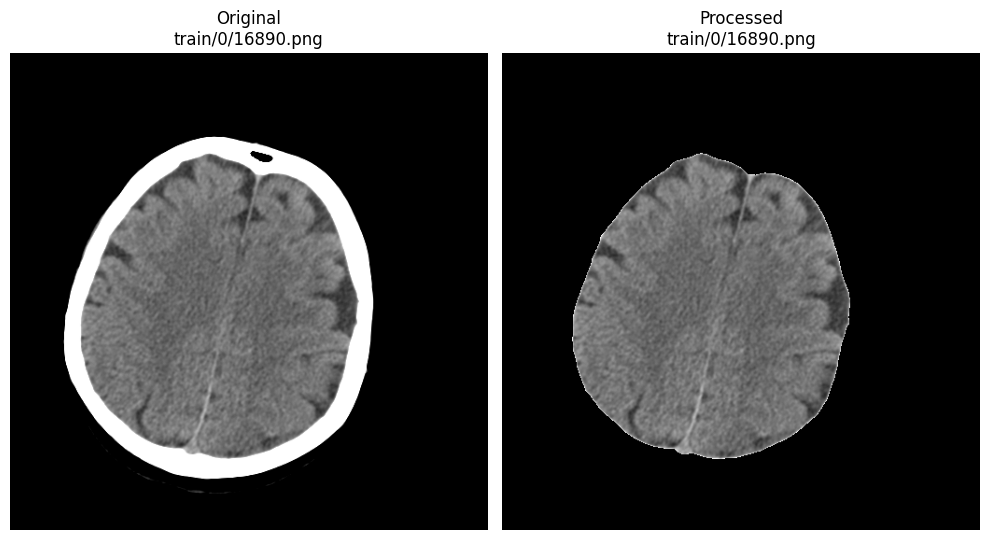

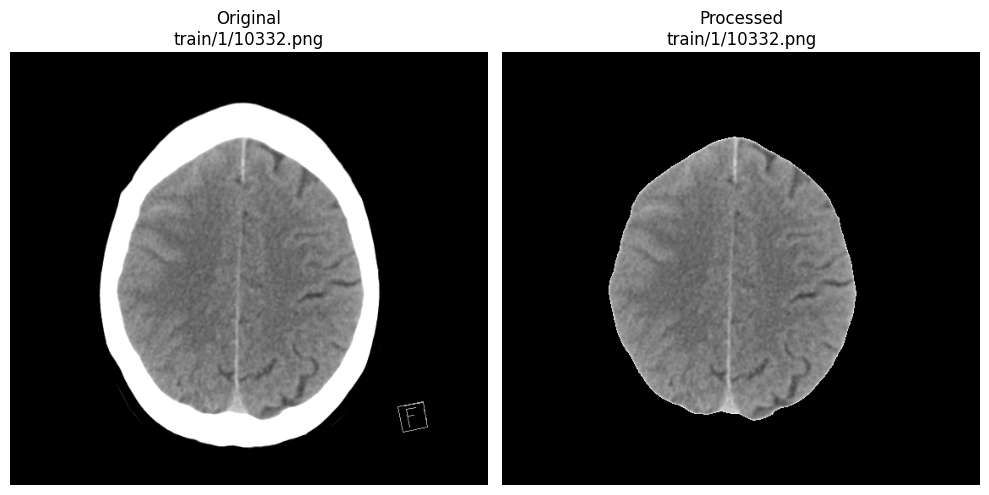

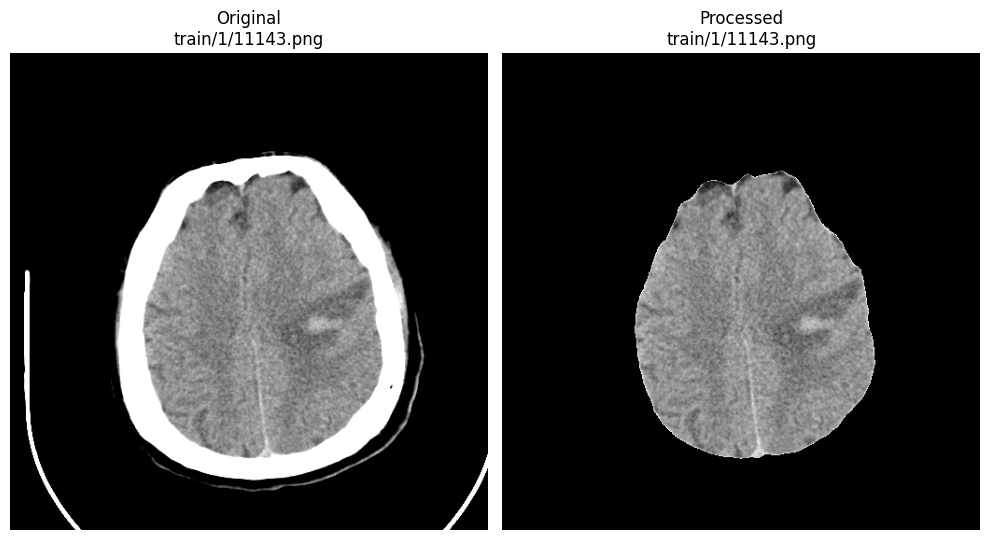

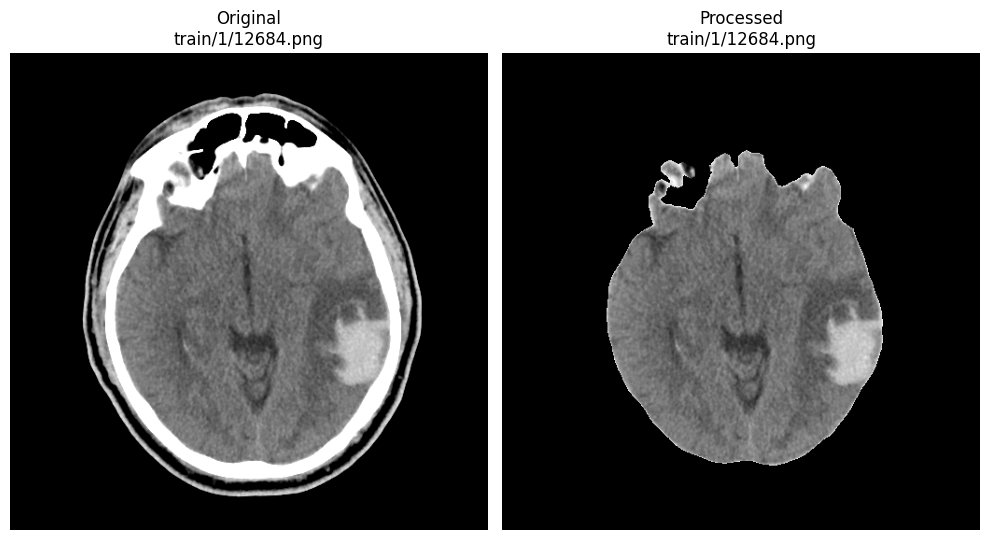

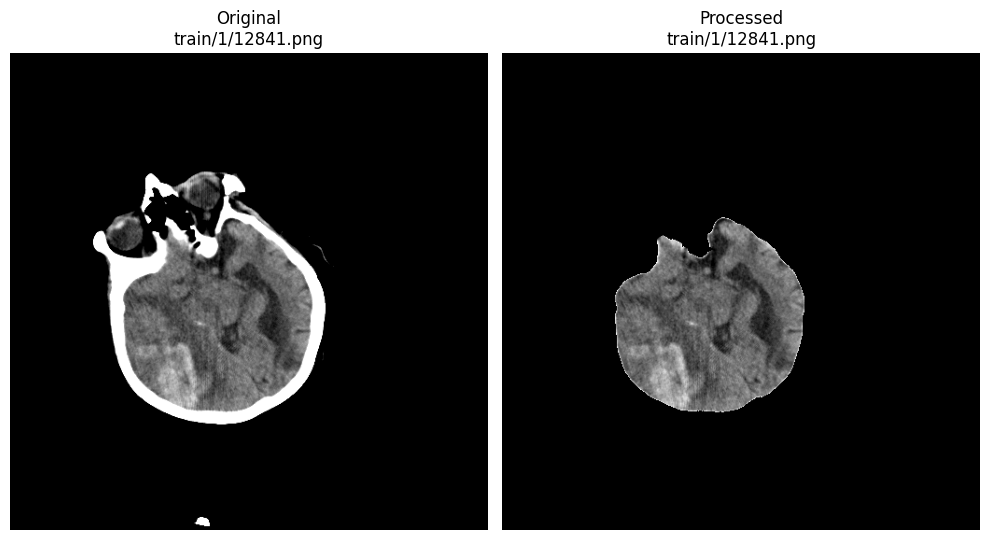

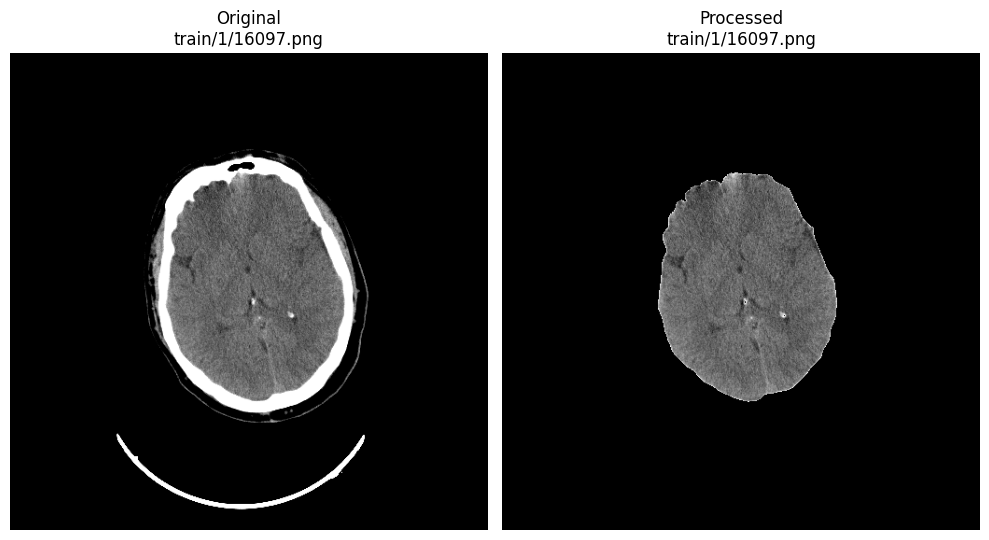

‚úÖ T√ºm i≈ülemler ba≈üarƒ±yla tamamlandƒ±!
Sonu√ßlar 'c:\Users\Ersin\Desktop\Biyomed\Quiz5\result' klas√∂r√ºne kaydedildi.


In [7]:
run_pipeline()

# 6. Klas√∂r Analiz Fonksiyonu

In [8]:
def analyze_image_counts():
    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, 'result')
    
    if not os.path.exists(RESULT_DIR):
        print("HATA: 'result' klas√∂r√º bulunamadƒ±! √ñnce i≈ülemleri √ßalƒ±≈ütƒ±rƒ±n.")
        return
    
    print("\n" + "="*50)
    print("RESƒ∞M SAYIM RAPORU")
    print("="*50)
    
    total_images = 0
    
    for dataset in ['train', 'test']:
        dataset_path = os.path.join(RESULT_DIR, dataset)
        if not os.path.exists(dataset_path):
            print(f"\n‚ö†Ô∏è Uyarƒ±: {dataset} klas√∂r√º bulunamadƒ±!")
            continue
            
        print(f"\nüìÇ {dataset.upper()} KLAS√ñR√ú")
        print("-"*40)
        
        class0_path = os.path.join(dataset_path, '0')
        class1_path = os.path.join(dataset_path, '1')
        
        # Class 0 sayƒ±mƒ±
        class0_count = 0
        if os.path.exists(class0_path):
            class0_count = len([f for f in os.listdir(class0_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Class 1 sayƒ±mƒ±
        class1_count = 0
        if os.path.exists(class1_path):
            class1_count = len([f for f in os.listdir(class1_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Dataset toplamƒ±
        dataset_total = class0_count + class1_count
        total_images += dataset_total
        
        # Rapor √ßƒ±ktƒ±sƒ±
        print(f"‚î£ 0/ klas√∂r√º: {class0_count} resim")
        print(f"‚î£ 1/ klas√∂r√º: {class1_count} resim")
        print(f"‚îó TOPLAM ({dataset}): {dataset_total} resim")
    
    print("\n" + "="*50)
    print(f"üìä GENEL TOPLAM: {total_images} resim")
    print("="*50)

# %% [markdown]
# # 7. Analiz Fonksiyonunu √áalƒ±≈ütƒ±r
# %%
analyze_image_counts()


RESƒ∞M SAYIM RAPORU

üìÇ TRAIN KLAS√ñR√ú
----------------------------------------
‚î£ 0/ klas√∂r√º: 4564 resim
‚î£ 1/ klas√∂r√º: 2383 resim
‚îó TOPLAM (train): 6947 resim

üìÇ TEST KLAS√ñR√ú
----------------------------------------
‚î£ 0/ klas√∂r√º: 1551 resim
‚î£ 1/ klas√∂r√º: 950 resim
‚îó TOPLAM (test): 2501 resim

üìä GENEL TOPLAM: 9448 resim


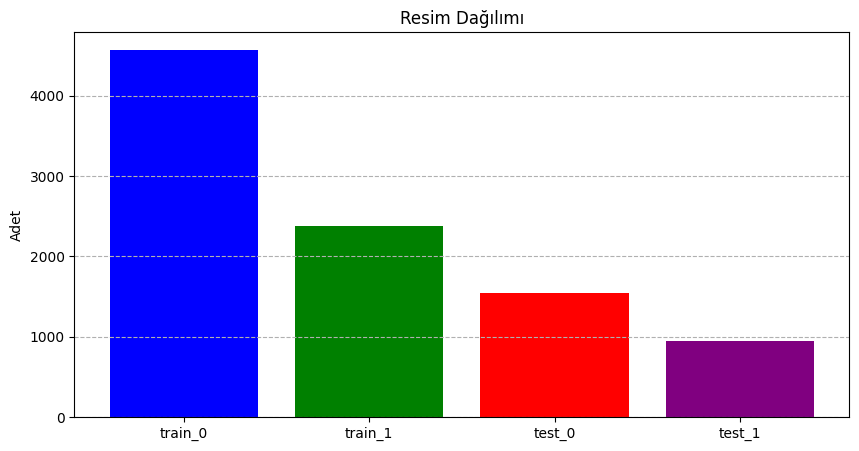

In [9]:
def visualize_counts():
    import matplotlib.pyplot as plt
    
    counts = {'train_0': 0, 'train_1': 0, 'test_0': 0, 'test_1': 0}
    
    for dataset in ['train', 'test']:
        for class_label in ['0', '1']:
            path = os.path.join('result', dataset, class_label)
            if os.path.exists(path):
                counts[f"{dataset}_{class_label}"] = len(
                    [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                )
    
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'green', 'red', 'purple'])
    plt.title('Resim Daƒüƒ±lƒ±mƒ±')
    plt.ylabel('Adet')
    plt.grid(axis='y', linestyle='--')
    plt.show()

visualize_counts()